/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
100%|██████████| 170M/170M [00:02<00:00, 65.8MB/s] 


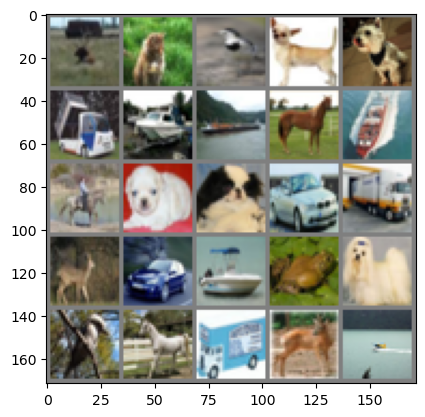

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(imgs):
    imgs = imgs / 2 + 0.5   # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.show()

# one batch of random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
imshow(img_grid)

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*4*4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # N, 3, 32, 32
        x = F.relu(self.conv1(x))   # -> N, 32, 30, 30
        x = self.pool(x)            # -> N, 32, 15, 15
        x = F.relu(self.conv2(x))   # -> N, 64, 13, 13
        x = self.pool(x)            # -> N, 64, 6, 6
        x = F.relu(self.conv3(x))   # -> N, 64, 4, 4
        x = torch.flatten(x, 1)     # -> N, 1024
        x = F.relu(self.fc1(x))     # -> N, 64
        x = self.fc2(x)             # -> N, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

[1] loss: 1.474
[2] loss: 1.106
[3] loss: 0.949
[4] loss: 0.846
[5] loss: 0.775
[6] loss: 0.712
[7] loss: 0.663
[8] loss: 0.615
[9] loss: 0.577
[10] loss: 0.541
Finished Training


In [3]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        n_correct2 += (predicted2 == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the model: {acc} %')

    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')


Accuracy of the model: 73.05 %
Accuracy of the loaded model: 73.05 %
